<h1 align='center'>Transformers from Scratch</h1>

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. Positional Encodings

$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{1}$$
<br>

$$
PE_{(pos, 2i+1)}= cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{2}$$

* $d$ is the dimension of the word embedding and positional encoding
* $pos$ is the position of the word.
* $k$ refers to each of the different dimensions in the positional encodings, with $i$ equal to $k$ $//$ $2$.

To develop some intuition about positional encodings, we can think of them broadly as a feature that contains the information about the relative positions of words. The sum of the positional encoding and word embedding is ultimately what is fed into the model. If we just hard code the positions in, say by adding a matrix of 1's or whole numbers to the word embedding, the semantic meaning is distorted. Conversely, the values of the sine and cosine equations are small enough (between -1 and 1) that when we add the positional encoding to a word embedding, the word embedding is not significantly distorted, and is instead enriched with positional information. Using a combination of these two equations helps our Transformer network attend to the relative positions of our input data.

### 1.1 - Sine and Cosine Angles

Notice that even though the sine and cosine positional encoding equations take in different arguments (`2i` versus `2i+1`, or even versus odd numbers) the inner terms for both equations are the same: $$\theta(pos, i, d) = \frac{pos}{10000^{\frac{2i}{d}}} \tag{3}$$

Consider the inner term as you calculate the positional encoding for a word in a sequence.<br> 
$PE_{(pos, 0)}= sin\left(\frac{pos}{{10000}^{\frac{0}{d}}}\right)$, since solving `2i = 0` gives `i = 0` <br>
$PE_{(pos, 1)}= cos\left(\frac{pos}{{10000}^{\frac{0}{d}}}\right)$, since solving `2i + 1 = 1` gives `i = 0`

The angle is the same for both! The angles for $PE_{(pos, 2)}$ and $PE_{(pos, 3)}$ are the same as well, since for both, `i = 1` and therefore the inner term is $\left(\frac{pos}{{10000}^{\frac{2}{d}}}\right)$. This relationship holds true for all paired sine and cosine curves:

|      k         | <code>       0      </code>|<code>       1      </code>|<code>       2      </code>|<code>       3      </code>| <code> ... </code> |<code>      d - 2     </code>|<code>      d - 1     </code>| 
| ---------------- | :------: | ----------------- | ----------------- | ----------------- | ----- | ----------------- | ----------------- |
| encoding(0) = |[$sin(\theta(0, 0, d))$| $cos(\theta(0, 0, d))$| $sin(\theta(0, 1, d))$| $cos(\theta(0, 1, d))$|... |$sin(\theta(0, d//2, d))$| $cos(\theta(0, d//2, d))$]|
| encoding(1) = | [$sin(\theta(1, 0, d))$| $cos(\theta(1, 0, d))$| $sin(\theta(1, 1, d))$| $cos(\theta(1, 1, d))$|... |$sin(\theta(1, d//2, d))$| $cos(\theta(1, d//2, d))$]|
...
| encoding(pos) = | [$sin(\theta(pos, 0, d))$| $cos(\theta(pos, 0, d))$| $sin(\theta(pos, 1, d))$| $cos(\theta(pos, 1, d))$|... |$sin(\theta(pos, d//2, d))$| $cos(\theta(pos, d//2, d))]$|


In [1]:
def get_angles(pos, k, d):
    """
    Get the angles for the positional encoding
    
    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        k --   Row vector containing the dimension span [[0, 1, 2, ..., d-1]]
        d(integer) -- Encoding size
    
    Returns:
        angles -- (pos, d) numpy array 
    """
    # Get the i from dimention span
    i = k // 2
    # Calculate the angles using pos, i and d
    angles = pos / 10000** (2*i/d)
    return angles

In [3]:
# Example
position = 4
d_model = 8
pos_m = np.arange(position)[:, np.newaxis]
dims = np.arange(d_model)[np.newaxis, :]
get_angles(pos_m, dims, d_model)

array([[0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [1.e+00, 1.e+00, 1.e-01, 1.e-01, 1.e-02, 1.e-02, 1.e-03, 1.e-03],
       [2.e+00, 2.e+00, 2.e-01, 2.e-01, 2.e-02, 2.e-02, 2.e-03, 2.e-03],
       [3.e+00, 3.e+00, 3.e-01, 3.e-01, 3.e-02, 3.e-02, 3.e-03, 3.e-03]])

Implementing the function `positional_encoding()` to calculate the sine and cosine  positional encodings

**Reminder:** Use the sine equation when $i$ is an even number and the cosine equation when $i$ is an odd number.

In [4]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # Initializing a matrix angle_rads of all the angles
    angle_rads = get_angles(np.arange(positions)[:, np.newaxis], np.arange(d)[np.newaxis, :], d)

    # Applying sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # Applying cos to odd indices in the array; 2i + 1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]   # adding new axis for batch_size

    return tf.cast(pos_encoding, dtype=tf.float32)

**Why Add a New Axis?**

The reason is for **batching**. Machine learning models are much more efficient when they process multiple sentences at once in a "batch," rather than one at a time.

Our (positions, d) matrix represents the positional information for a single sentence.

The model expects to receive a batch of sentences. So, the input shape needs to be `(batch_size, positions, d)`.

By adding `np.newaxis`, we're adding that `batch_size` dimension. We set it to 1 for now, making our shape (1, 50, 512). This makes it ready to be combined with our actual word embeddings, which will also be organized in batches.

(1, 50, 512)


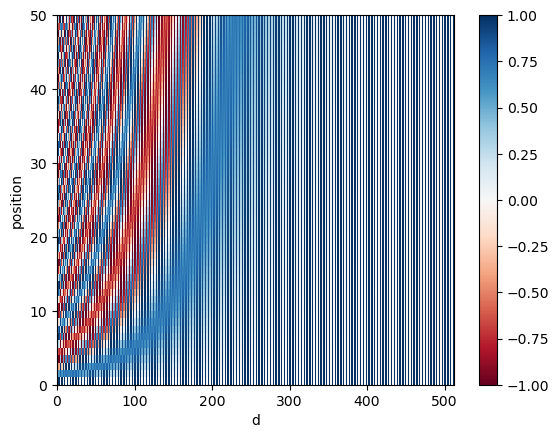

In [7]:
pos_encodings = positional_encoding(50, 512)
print(pos_encodings.shape)

plt.pcolormesh(pos_encodings[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0,512))
plt.ylabel('position')
plt.colorbar()

Let's look a little closer at what's happening. Instead of the values just "increasing," think of them as waves.

- **Low Dimensions (left side):** These are very long, slow waves, like a deep bass note. They change gradually across the sentence positions. We can see this in the broad, smooth bands of color.

- **High Dimensions (right side):** These are extremely fast, high-frequency waves, like a high-pitched whistle. They change so rapidly from one position to the next that they just look like noise or static on this plot.

This mix of low and high-frequency waves is what gives each position its unique ***"fingerprint."*** It allows the model to easily figure out the relative positions of words. For example, if it wants to know if two words are close together, it might look at the high-frequency waves. If it wants to know a word's general location in a long sentence, it might look at the low-frequency waves.

# 2. Masking

### 2.1 Padding Mask

So, why do we need a padding mask?

When we train a model, we usually feed it a "batch" of sentences at once. But sentences aren't all the same length. To make them fit into a nice, rectangular tensor, we "pad" the shorter ones with zeros until they're all as long as the longest sentence in the batch.

The problem is, we don't want the model to treat these zeros as actual words. The **padding mask** is how we tell the model, "Hey, these zeros are just filler. Please ignore them."

In [8]:
def create_padding_mask(decoder_token_ids):
    """
    Creates a boolean mask for the padding cells
    
    Arguments:
        decoder_token_ids -- (n, m) matrix
    
    Returns:
        mask -- (n, 1, m) boolean tensor
    """
    seq = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)
    # add extra dimensions to add the padding
    # to the attention logits. 
    # this will allow for broadcasting later when comparing sequences
    
    return seq[:, tf.newaxis, :]

Let's break down that first line from the inside out. It does three things:

- `tf.math.equal(decoder_token_ids, 0)`: This checks every token in our input and returns `True` if the token is a 0 (padding) and `False` otherwise.

- `tf.cast(..., tf.float32)`: This converts the booleans to numbers. True becomes `1.0` and False becomes `0.0`. So now we have a mask where `1.0` represents the padding.

- `1 - ...`: This inverts the mask. Now, `1.0` represents the real words and `0.0` represents the padding. This is the format that TensorFlow's attention mechanism expects.

The reason we add this new dimension is to make the mask compatible with the **attention scores matrix**, which has a more complex shape. Think of it like this:

- The attention scores will have a shape of `(batch_size, num_heads, sequence_length, sequence_length)`. This is because we calculate attention for each word in the sequence (the rows), against every other word in the sequence (the columns), for every attention head, in every batch.

- Our padding mask only cares about which words in the sequence are padding. It has a shape of `(batch_size, sequence_length)`.

To apply our simple mask to the complex attention score matrix, we need to make their dimensions compatible. By adding a new axis to make the mask's shape `(batch_size, 1, 1, sequence_length)`, we allow TensorFlow's broadcasting mechanism to "stretch" the mask across all the heads and all the query positions.

It's an efficient way to apply the same rule—***"ignore the padding tokens"***—everywhere it's needed during the attention calculation.

In [9]:
x = tf.constant([[7., 6., 0., 0., 1.], [1., 2., 3., 0., 0.], [0., 0., 0., 4., 5.]])
print(create_padding_mask(x))

tf.Tensor(
[[[1. 1. 0. 0. 1.]]

 [[1. 1. 1. 0. 0.]]

 [[0. 0. 0. 1. 1.]]], shape=(3, 1, 5), dtype=float32)


### 2.2 Look Ahead Mask

The look-ahead mask follows similar intuition. In training, you will have access to the complete correct output of your training example. The look-ahead mask helps your model pretend that it correctly predicted a part of the output and see if, *without looking ahead*, it can correctly predict the next output.

In [10]:
def create_look_ahead_mask(sequence_length):
    """
    Returns a lower triangular matrix filled with ones
    
    Arguments:
        sequence_length -- matrix size
    
    Returns:
        mask -- (size, size) tensor
    """
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask

Here is what this function does:
- `tf.ones(...)` creates a square matrix full of ones. If `sequence_length` is 3, its shape is `(1, 3, 3)`.

- `tf.linalg.band_part(..., -1, 0)` is the key part. It takes this matrix of ones and zeros out everything above the main diagonal, creating what's called a **lower triangular matrix**.

When this mask is used in the attention calculation, the zeros will effectively block the model from seeing future tokens.

In [11]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]]], dtype=float32)>

Here, when predicting the word at Position 2, it is allowed to see the word at position 0, 1, and 2, and we might think, it is not "**predicting**" anything, it is just copying the answer.

Here's the trick: what the model sees as **input** is different from what it's asked to predict as **output**.

We feed the decoder the entire sequence at once for efficiency, but we shift the output we're asking it to predict. It works like this:

- When the model is at position 0 ("I"), we ask it to predict the word at position 1 ("am").

- When the model is at position 1 ("am"), we ask it to predict the word at position 2 ("learning").

- When the model is at position 2 ("learning"), we ask it to predict a special "end of sentence" token.

The look-ahead mask is what enforces this. Even though the whole sentence "I am learning" is technically available, the mask ensures that:

- The calculation for position 0 only uses information from "I".

- The calculation for position 1 only uses information from "I am".

- The calculation for position 2 only uses information from "I am learning".

This allows us to train the model on all the prediction steps in a sentence in a single, parallel pass. It's a very clever trick for efficient training!

# 3. Self-Attention

The use of self-attention paired with traditional convolutional networks allows for parallelization which speeds up training. We will implement **scaled dot product attention** which takes in a query, key, value, and a mask as inputs to return rich, attention-based vector representations of the words in your sequence. This type of self-attention can be mathematically expressed as:
$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{4}\
$$

* $Q$ is the matrix of queries 
* $K$ is the matrix of keys
* $V$ is the matrix of values
* $M$ is the optional mask you choose to apply 
* ${d_k}$ is the dimension of the keys, which is used to scale everything down so the softmax doesn't explode

So what exactly are **Query (Q)**, **Key (K)** and **Value (V)**?

- **Query (Q)**: This is the current word that's "asking" for information. Think of it as saying, "I'm the word 'it', who in this sentence is relevant to me?"

- **Key (K)**: These are all the words in the sentence "offering" information. Each key says, "I'm the word 'animal', and here's what I'm about."

- **Value (V)**: This is the actual information that gets passed along. Once a query finds a key it's interested in, it takes that key's corresponding value.

Implementing the function `scaled_dot_product_attention()` to create attention-based representations.

**Reminder**: 
- The boolean mask parameter can be passed in as `none` or as either padding or look-ahead. 
- Multiplying (1. - mask) by -1e9 before applying the softmax.

In [12]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

    Arguments:
        q -- query shape == (..., seq_len_q, depth)
        k -- key shape == (..., seq_len_k, depth)
        v -- value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  #(..., seq_length_q, seq_lenth_k)

    # Scaled matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)   # takes the last dimension of k, i.e. depth
    scaled_attention_logits = matmul_qk / tf.sqrt(dk)

    # Adding mask to scaled Tensor
    if mask is not None:
        scaled_attention_logits += (1. - mask) * -1e9

    # Softmax is normalized on the last axis so that the score adds up to 1
    attention_weights = tf.keras.activations.softmax(scaled_attention_logits, axis=-1)   #(..., seq_length_q, seq_lenth_k)

    outputs = tf.matmul(attention_weights, v)   #(..., seq_length_q, depth_v)

    return outputs, attention_weights

Here when we are applying Softmax on attention weights we are using `axis=-1` which tells the softmax function "For each **query word** (`seq_len_q`), calculate the probabilities across all the **key words** (`seq_len_k`)".

This ensures that for each word in our sentence, we get a proper probability distribution that adds up to 1 over all the words it could potentially pay attention to. It's how we decide where to "spend" our single unit of attention for each word.

# 4. Encoder

### 4.1 EncoderLayer

* `MultiHeadAttention` we can think of as computing the self-attention several times to detect different features. 
* Feed forward neural network contains two Dense layers which we'll implement as the function `FullyConnected`

Our input sentence first passes through a *multi-head attention layer*, where the encoder looks at other words in the input sentence as it encodes a specific word. The outputs of the multi-head attention layer are then fed to a *feed forward neural network*. The exact same feed forward network is independently applied to each position.

In [15]:
def FullyConnected(embedding_dim, fully_connected_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=fully_connected_dim),
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),   # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(embedding_dim)   # (batch_size, seq_len, embedding_dim)
    ])

In [16]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network. 
    This architecture includes a residual connection around each of the two 
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        super(EncoderLayer, self).__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim,dropout=dropout_rate)
        
        self.ffn = FullyConnected(
            embedding_dim=embedding_dim, fully_connected_dim=fully_connected_dim)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            encoder_layer_out -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """

        # Calculating self-attention using mha
        self_mha_output = self.mha(x, x, x, attention_mask=mask, training=training)
        
        # Skip Connection
        # Applying layer normalization on the sum of input and the attention output to get the output of MHA layer
        skip_x_attention = self.layernorm1(x + self_mha_output)   # (batch_size, input_seq_len, embedding_dim)

        # Pass the output of mha layer to ffn
        ffn_output = self.ffn(skip_x_attention)

        # Applying Dropout
        ffn_output = self.dropout_ffn(ffn_output, training=training)
        
        # Applying Layer normalization on the sum of the output of mha (skip connection) and ffn output to get the output of encoder layer
        encoder_layer_output = self.layernorm2(skip_x_attention + ffn_output)   # (batch_size, input_seq_len, embedding_dim)

        return encoder_layer_output

**Residual Connection** (or *skip connection*), think of it like this:

- We start with our original input vectors `x`.

- The self-attention layer creates new, context-rich vectors (`self_mha_output`).

- The residual connection takes our original input `x` and adds it to these new vectors.

This ensures that we don't lose the original information (like the word's basic meaning and position) as we pass it through the layer. It makes it easier for the model to learn and is crucial for training very deep networks.

### 4.2 Full Encoder

In [21]:
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    encoder Layers
        
    """ 
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
                 maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                       num_heads=num_heads,
                                       fully_connected_dim=fully_connected_dim,
                                       dropout_rate=dropout_rate,
                                       layernorm_eps=layernorm_eps)
                        for _ in range(self.num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, mask):
        """
        Forward pass for the Encoder
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        seq_len = tf.shape(x)[1]

        # Passing input through the Embedding layer
        x = self.embedding(x)   # (batch_size, input_seq_len, embedding_dim)
        
        # Scaling Embedding
        x *= tf.math.sqrt(tf.cast(tf.shape(x)[-1], dtype=tf.float32))

        # Adding Positional Encodings
        x += self.pos_encoding[:, :seq_len, :]

        # Dropout
        x = self.dropout(x, training=training)

        # Passing the output through the stack of encoding layers
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)

        return x # (batch_size, input_seq_len, embedding_dim)

# 5. Decoder

### 5.1 Decoder Layer

1. **Masked Multi-Headed Self-Attention** (Block 1): his first part is almost identical to the self-attention in the Encoder. It lets the Decoder look at the words it has generated so far to understand its own context. The key difference is that it uses the look-ahead mask to prevent it from cheating and looking at future words.
2. **Encoder-Decoder Attention (Cross-Attention)** (Block 2): This is the most crucial sub-layer. Here, the model takes the output from the Encoder and combines it with the output from the Decoder's self-attention. This is where the Decoder looks at the original input sentence to decide which parts are most relevant for predicting the very next word.
3. **Feed-Forward Network**: This is identical to the one in the Encoder. It's a final processing step.
    
* The first two blocks are fairly similar to the `EncoderLayer` except we will return `attention_scores` when computing self-attention

In [22]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed by two multi-head attention blocks, 
    one that takes the new input and uses self-attention, and the other 
    one that combines it with the output of the encoder, followed by a
    fully connected block. 
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        self.mha1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,
                                                       key_dim=embedding_dim,
                                                       dropout=dropout_rate)
        
        self.mha2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,
                                                       key_dim=embedding_dim,
                                                       dropout=dropout_rate)
        
        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            out3 -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attn_weights_block1 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
            attn_weights_block2 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
        """

        # enc_output.shape == (batch_size, input_seq_len, embedding_dim)

        # BLOCK 1
        # Calculating self attention and returning attention score
        mult_attn_out1, attn_weights_block1 = self.mha1(
            x, x, x, attention_mask=look_ahead_mask, return_attention_scores=True)   # (batch_size, target_seq_len, embedding_dim)

        # Applying Layer Normalization to the sum of attention output and input
        Q1 = self.layernorm1(mult_attn_out1 + x)


        # BLOCK 2
        # Calculating the self_attention using Q from the 1st block and K, V from the encoder output
        mult_attn_out2, attn_weights_block2 = self.mha2(
            Q1, enc_output, enc_output, attention_mask=padding_mask, return_attention_scores=True)   # (batch_size, target_seq_len, embedding_dim)

        # Applying Layer Normalization to the sum of attention output and the output from the 1st block
        mult_attn_out2 = self.layernorm2(mult_attn_out2 + Q1)   # (batch_size, target_seq_len, embedding_dim)


        # BLOCK 3
        # Passing the output of the 2nd block through ffn
        ffn_output = self.ffn(mult_attn_out2)

        # Applying the Dropout
        ffn_output = self.dropout_ffn(ffn_output, training=training)

        # Applying the Layer Normalization to the sum of ffn output and output of the 2nd block
        out3 = self.layernorm3(ffn_output + mult_attn_out2)

        return out3, attn_weights_block1, attn_weights_block2

### 5.2 Fully Decoder

In [23]:
class Decoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the target input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    decoder Layers
        
    """ 
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, 
                 target_vocab_size, maximum_position_encoding,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layer = [DecoderLayer(embedding_dim=self.embedding_dim,
                                       num_heads=num_heads,
                                       fully_connected_dim=fully_connected_dim,
                                       dropout_rate=dropout_rate,
                                       layernorm_eps=layernorm_eps)
                        for _ in range(self.num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attention_weights - Dictionary of tensors containing all the attention weights
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # Creating Word Embeddings
        x = self.embedding(x)   # (batch_size, target_seq_len, embedding_dim)

        # Scaling Embeddings
        x *= tf.math.sqrt(tf.cast(tf.shape(x)[-1], dtype=tf.float32))

        # Calculating Positional Encodings and adding to the word Embeddings
        x += self.pos_encoding[:, :seq_len, :]

        # Applying Dropout
        x = self.dropout(x, training=training)

        # Using for loop to pass x through the stack of decoding layer and update attention weights
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layer[i](x, enc_output, training, look_ahead_mask, padding_mask)

            # Updating attention weights
            attention_weights['decoder_layer{}_block1_self_att'.format(i + 1)] = block1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i + 1)] = block2

        return x, attention_weights

# 6. Transformer

In [24]:
class Transformer(tf.keras.layers.Layer):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
                 targer_vocab_size, max_position_encoding_input, max_position_encoding_target,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_position_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)
        
        self.decoder = Decoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=targer_vocab_size,
                               maximum_position_encoding=max_position_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)
        
        self.final_layer = tf.keras.layers.Dense(targer_vocab_size, activation='softmax')

    def call(self, input_sentence, output_sentence, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Forward pass for the entire Transformer
        Arguments:
            input_sentence -- Tensor of shape (batch_size, input_seq_len)
                            An array of the indexes of the words in the input sentence
            output_sentence -- Tensor of shape (batch_size, target_seq_len)
                            An array of the indexes of the words in the output sentence
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            enc_padding_mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
            look_ahead_mask -- Boolean mask for the target_input
            dec_padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            final_output -- Describe me
            attention_weights - Dictionary of tensors containing all the attention weights for the decoder
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        
        """
        
        enc_output = self.encoder(input_sentence, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(output_sentence, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights